#  SDCND: Deep Learning for Traffic Sign Recognition 

---
## Step 0: Load The Data / Helper Methods 

In [1]:
import numpy as np 
import pickle

training_file ='train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


### Helper Methods

In [2]:
# In case you were wondering, I come from more of an R background. 
def which(bools_list): 
    return [i for i,val in enumerate(bools_list) if val]

---

## Step 1: Dataset Summary & Exploration (edit this stuff...) 


In [3]:
n_train = len(y_train)
n_test = len(y_test)
image_shape = (X_train.shape[1], X_train.shape[2])
image_width = image_shape[1]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image width =", image_width)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Image width = 32
Number of classes = 43


In [4]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.gridspec as pltgs

import cv2

%matplotlib inline

### Figure 1

Aside from establishing a working familiarity with the provided 
dataset, the objective of our visualization is to inform the structure of the neural 
network we will ultimately use.

This being the case, we begin with a mosaic of a randomly selected example from each 
of our 43 classes. It's simpler to just select one element explicitly, but if we mix it up like this, 
whenever we run the script, we might get some new insight by seeing an image we haven't seen before. We 
can't inspect every possible image, so this is one silly way of adressing 'the model-builder's bias.' 

For obvious reasons, including what was mentioned above, we only visualize examples 
in the training set. 

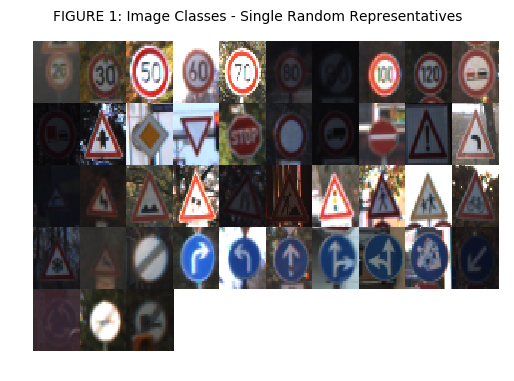

In [5]:
figure_1_images = list(map(lambda label: X_train[np.random.choice(which(y_train == label))], np.unique(y_train)))
figure_1_row_length = 10

figure_1 = plt.figure(1)
for i in range(0, len(figure_1_images)):
    figure_1_ax = figure_1.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)    
    figure_1_ax.imshow(figure_1_images[i], figure=figure_1, aspect='auto', interpolation='nearest')
    figure_1_ax.axis('off')
figure_1.subplots_adjust(wspace=0, hspace=0)
figure_1.suptitle('FIGURE 1: Image Classes - Single Random Representatives')


### Figure 2

Now, given that we have 43 classes (above) we visualize the distribution of these classes 
in our training dataset. A heavy class imbalance is self-evident, and will need to be 
accounted for in the model architecture below. 

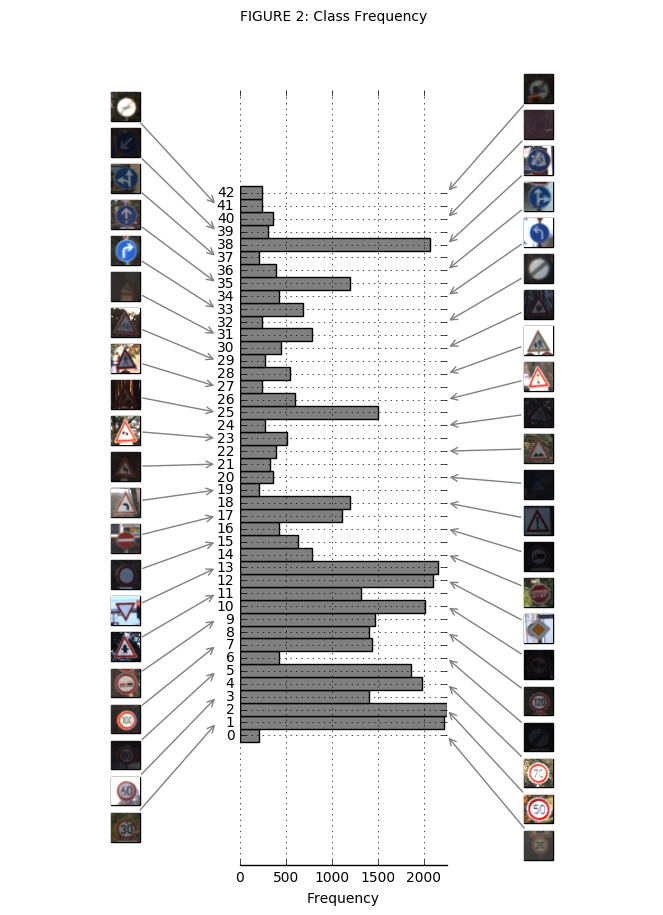

In [6]:
figure_2_labels,figure_2_freq = np.unique(y_train, return_counts=True)

figure_2_grid = pltgs.GridSpec(1,3)
figure_2 = plt.figure(2, figsize=(8,10))

figure_2_ax1 = figure_2.add_subplot(figure_2_grid[1])
figure_2_ax1.barh(figure_2_labels, figure_2_freq, 1, align='center', color='gray')
figure_2_ax1.grid(True)
figure_2_ax1.set_xlim([0,max(figure_2_freq)])

figure_2_ax1.spines['top'].set_visible(False)
figure_2_ax1.spines['right'].set_visible(False)
figure_2_ax1.spines['left'].set_visible(False)
plt.yticks(figure_2_labels, figure_2_labels, figure=figure_2)
plt.xlabel('Frequency')

# The coordinates of the thumbnails are computed in [0,60] and are then translated 
# down, so that they are centred w.r.t the left side of the figure. 
figure_2_thumbnail_coords_y = np.arange(0, 60, 60.0/len(figure_1_images))

figure_2_ax2 = figure_2.add_subplot(figure_2_grid[2],sharex=figure_2_ax1, sharey=figure_2_ax1)
for i in range(0, len(figure_1_images), 2):
    image_current  = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_2_ann = AnnotationBbox(image_current, 
                                 xybox=[1000, figure_2_thumbnail_coords_y[i]-(60-len(figure_1_images))/2],
                                 xycoords='data',
                                 xy=[0,i],
                                 arrowprops=dict(arrowstyle="->", color='gray'),
                                 pad=0)
    figure_2_ax2.add_artist(figure_2_ann)
    plt.axis('off') 

figure_2_ax3 = figure_2.add_subplot(figure_2_grid[0],sharex=figure_2_ax1, sharey=figure_2_ax1)
for i in range(1, len(figure_1_images), 2):
    image_current  = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_2_ann = AnnotationBbox(image_current, 
                                 xybox=[1000, figure_2_thumbnail_coords_y[i]-(60-len(figure_1_images))/2],
                                 xycoords='data',
                                 xy=[2000,i],
                                 arrowprops=dict(arrowstyle="->", color='gray'),
                                 pad=0)
    figure_2_ax3.add_artist(figure_2_ann)
    plt.axis('off') 

    
figure_2.subplots_adjust(wspace=0, hspace=0)                            
figure_2.suptitle('FIGURE 2: Class Frequency')


### Figure 3 

We examine the histograms of the random subset of images displayed in *Figure 1*. This will serve to demonstrate the extent of the contrast variation between the images in our training set. 

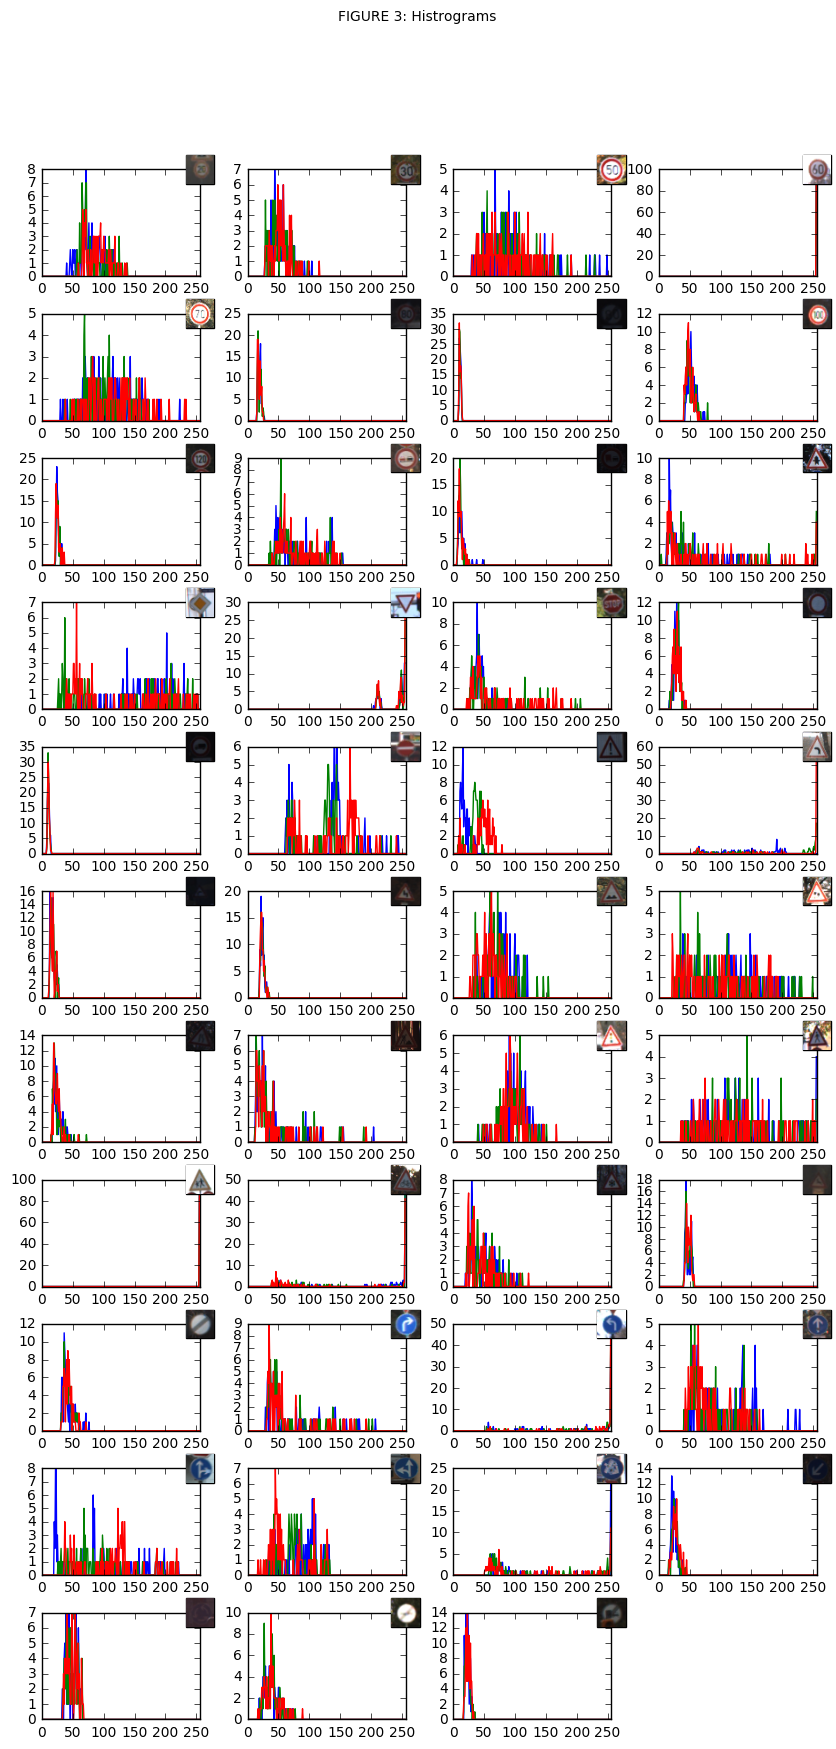

In [7]:
figure_3_row_length = 4

figure_3 = plt.figure(3, figsize=(10, 20))
for i in range(0, len(figure_1_images)):
    figure_3_ax = figure_3.add_subplot(np.ceil(len(figure_1_images)/figure_3_row_length), figure_3_row_length, i+1)
    for j,col in enumerate(('b', 'g', 'r')):
        figure_3_subhist = cv2.calcHist(figure_1_images[i], [j], None, [256], [0,256])
        figure_3_ax.plot(figure_3_subhist, color=col)
        figure_3_ax.set_xlim([0,256])
   
    # Give us a little thumbnail of the image to look at 
    image_current = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_3_ann = AnnotationBbox(image_current,
                                xybox=[1, 1],
                                xy=[1, 1],
                                xycoords='axes fraction',
                                pad=0)
    figure_3_ax.add_artist(figure_3_ann)
        
figure_3.subplots_adjust(wspace=0.3, hspace=0.35)
figure_3.suptitle('FIGURE 3: Histrograms')

As is evident in the figure above, histogram normalization will likely greatly aid model performance. 

----

## Step 2: Design and Test a Model Architecture


### Relevant Litterature 
The model and pre-processing phases are inspired by the following published material: 
**Note:** A number of the articles mentioned below are not open access. Until my official graduation from my M.Sc., I have institutional access. 

**[1]** Cireşan, D., U. Meier, J. Masci, and J. Schmidhuber. 2011. “A Committee of Neural Networks for Traffic Sign Classification.” In The 2011 International Joint Conference on Neural Networks, 1918–21.

**[2]** Sermanet, Pierre, and Yann LeCun. 2011. “Traffic Sign Recognition with Multi-Scale Convolutional Networks.” In Neural Networks (IJCNN), The 2011 International Joint Conference on, 2809–13.

**[3]** Ruta, Andrzej, Yongmin Li, and Xiaohui Liu. 2010/1. “Real-Time Traffic Sign Recognition from Video by Class-Specific Discriminative Features.” Pattern Recognition 43 (1): 416–30.

**[4]** Stallkamp, J., M. Schlipsing, J. Salmen, and C. Igel. 2012. “2012 Special Issue: Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition.” Neural Networks: The Official Journal of the International Neural Network Society 32 (August). Oxford, UK, UK: Elsevier Science Ltd.: 323–32.

**[5]** Escalera, A. de la, J. M. Armingol, and M. Mata. 2003. “Traffic Sign Recognition and Analysis for Intelligent Vehicles.” Image and Vision Computing 21 (3): 247–58.

**[6]** Maldonado-Bascon, S., S. Lafuente-Arroyo, P. Gil-Jimenez, H. Gomez-Moreno, and F. Lopez-Ferreras. 2007. “Road-Sign Detection and Recognition Based on Support Vector Machines.” IEEE Transactions on Intelligent Transportation Systems 8 (2): 264–78.

### Helper Methods

In [8]:
# Imports
import tensorflow as tf 
import cv2

def clahe(img, clipLimit, tileGridSize): 
    """ Apply Contrast-Limited Adaptive Histogram Equalization with OpenCV
    
    The image is converted to HLS space, and CLAHE is applied. The image 
    is then converted to RGB space, and is returned. 
    
    Args:
        img: Input image, should be in BGR colorspace. 
        clipLimit: Passed to cv2.createCLAHE
        tileGridSize: Passed to cv2.createCLAHE
    
    Returns: 
        The input image, with CLAHE applied, in RGB
    """
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h,l,s = cv2.split(img)
    
    img_clahe   = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_clahe_l = img_clahe.apply(l)
    
    img_ret = cv2.merge((h, img_clahe_l, s))
    img_ret = cv2.cvtColor(img_ret, cv2.COLOR_HLS2RGB)
    return(img_ret)

### Dataset preparation and feature augmentation

Prior to the definition of a neural network architecture, the data is preprocessed. As is evident from the random sampling of the images, shown above, there is a vast All methods cited above involve some degree of preprocessing. Both **[1]** and **[2]** apply global normalization, with **[2]** opting for contrast-limited adaptive histogram equalization (CLAHE) whereby normalization is applied in a tiles across the image, and image is contrast is limited to avoid the amplification of image noise. [The OpenCV documentation provides a  description of the procedure](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html). The CLAHE procedure is applied here, and its effect may be visualized below, on the set of sample images in *Figure 1*.  

### Figure 4
CLAHE applied to the set of sample images in *Figure 1*. Note the increased visibility of the road signs, particularly in the darker images. As both ... (GRAYSCALE NOT SO BAD ACCORDING TO PUBS)...

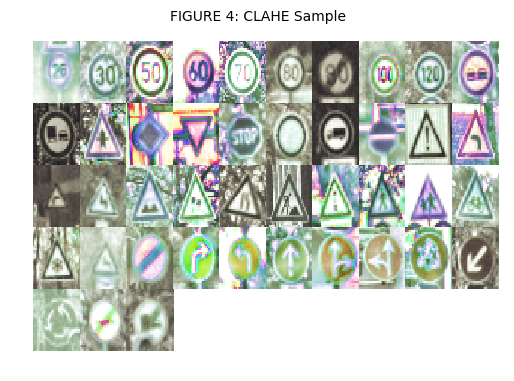

In [18]:
figure_4 = plt.figure(4)
for i in range(0, len(figure_1_images)):
    figure_4_ax = figure_4.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)
    img_clahe = clahe(figure_1_images[i], clipLimit=2.0, tileGridSize=(4,4))
    figure_4_ax.imshow(img_clahe, aspect='auto', interpolation='nearest')
    figure_4_ax.axis('off')
    
figure_4.subplots_adjust(wspace=0, hspace=0)
figure_4.suptitle('FIGURE 4: CLAHE Sample')


### Model Architecture

In [10]:
# Constants
TF_EPOCHS = 20 
TF_BATCHS = 128

# Apply CLAHE normalization to the training and testing set. 


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.